## Sudoku solver using - Genetic Algorithm

### Import the file with the fitness_functions and some libraries

In [78]:
from sudoku_function import *   # File that contains the objective functions to solve

import math
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
from statistics import mean
import random

**Chromosome - Sudoku class**

In [79]:
# Create two matrix, one with all the numbers of the sudoku puzzle and another with the given-numbers

class Chromosome:
    
    def __init__(self, N, index, general_matrix=None, binary_matrix=None):
        
        self.elements = N
        self.index = index
        self.fitness = None
        self.values = np.arange(1, N+1)
        
        if general_matrix is not None:
            
            self.general_matrix = general_matrix
            
        if binary_matrix is not None:
            
            self.binary_matrix = binary_matrix
        
    
    def randomInitialize(self, given_numbers_matrix, function, index):
        
        """
        Create two matrices based on the given_numbers_matrix
        """
        
        N = given_numbers_matrix.shape[1] # Number of columns
        
        
        # Binary matrix
        
        binary_matrix = np.where(given_numbers_matrix != 0, 1, 0)
        
        # General matrix
        
        new_matrix = given_numbers_matrix.copy()
        
        values = self.values # All the possible values for the sudoku puzzle
        
        # Identify the established numbers
        
        
        for i in range(N): # Iterate over each row
            
            fixed_cols = np.where(new_matrix[i] != 0)[0]
#             print("Fixed cols", fixed_cols)
            
            # Generate values for the remaining values
            
            remaining_values = np.setdiff1d(values, new_matrix[i, fixed_cols])
            shuffled_values = np.random.permutation(remaining_values)
            
            # Assign the shuffled values to the corresponding columns
            
            new_matrix[i, new_matrix[i] == 0] = shuffled_values
        
        # Assign all the values
        
        self.index= index
        self.general_matrix = new_matrix
        self.binary_matrix = binary_matrix
        self.evaluateFunction(function)
        
            
    def printChromosome(self):
        
        """
        Print the Chromosome's elements
        """
        
        print("General matrix:")
        print(self.general_matrix)
        
#         print("Binary matrix:")
#         print(self.binary_matrix)
        
        print("Fitness:", self.fitness)
        print("Index:", self.index)
        
    
    def evaluateFunction(self, function):
        
        """
        Obtain the fitness value of the individual from the sudoku_function file
        """
        
        self.fitness = function(self.general_matrix, self.elements)
        
        
    def column_search(self):
        
        """
        Perform a local search among all the columns of the individual
        """
        
        
        # Obtain a set C, which will contain the illegal columns
        
        set_C = self.obtain_illegal_columns()
        
        for index_col in set_C:
            
#             current_column = self.general_matrix[:, index_col]
            index_other_col = random.choice(set_C)
#             other_column = self.general_matrix[:, index_other_col]
            self.swap_columns(index_col, index_other_col)
        
        
    def obtain_illegal_columns(self):

        """
        Obtain a set C which contain the illegal columns of the Chromosome
        """

        set_C = []

        # Iterate over each column

        for i in range(self.elements):

            # Get unique values and their counts for the current column

            unique_values, counts = np.unique(self.general_matrix[:, i], return_counts=True)

            # Check if the current column have any repeated values in the current column

            if np.any(counts > 1):

                set_C.append(i)

        return set_C
        
        
    def swap_columns(self, index1, index2):

        """
        Try to swap row elements on each illegal column
        """

        # Obtain the columns based on the indexes
        
        column1 = self.general_matrix[:, index1].copy()
        column2 = self.general_matrix[:, index2].copy()
        
#         print("Original columns")
#         print(column1)
#         print(column2)
        
        # Obtain the repeated values in each column
        
        values_column1 = np.where(np.bincount(column1) > 1)[0]
        values_column2 = np.where(np.bincount(column2) > 1)[0]
        
#         print("Values columns")
#         print(values_column1)
#         print(values_column2)

        
        # Obtain the indexes of repeated values in each column
        
        indexes_column1 = np.where(np.isin(column1, values_column1))[0]
        indexes_column2 = np.where(np.isin(column2, values_column2))[0]
        
#         print("Indexes columns")
#         print(indexes_column1)
#         print(indexes_column2)


        # Obtain the indexes that are in both repeated_column variables

        common_index = np.intersect1d(indexes_column1, indexes_column2)
#         print("Common_index")
#         print(common_index)


        for i in common_index:

            if ~np.isin(column1[i], column2) and ~np.isin(column2[i], column1):
                
                if self.binary_matrix[i, index1] != 1 and self.binary_matrix[i, index2] != 1:
                    

                    aux_value = column1[i]

                    column1[i] = column2[i]

                    column2[i] = aux_value
                
#                     print("Exchange performed")
#                     print(column1)
#                     print(column2)

#         print("Final Columns")
#         print(column1)
#         print(column2)

        self.general_matrix[:, index1] = column1
        self.general_matrix[:, index2] = column2
        
        
    def sub_Block_search(self):

        """
        Perform a local search among all the sub_blocks of the individual
        """

        # Obtain a set S, which will contain the illegal columns

        set_S = self.obtain_illegal_sublocks()

        for index_block in set_S:

            index_other_block = random.choice(set_S)
            self.swap_sub_Block(index_block, index_other_block)


    def obtain_illegal_sublocks(self):

        """
        Obtain a set S which contain the illegal sub_block of the Chromosome
        """

        set_S = []

        # Iterate over each sublock

        rows = columns = self.elements

        block_size = int(np.sqrt(self.elements))

        for i in range(0, rows, block_size):

            for j in range(0, columns, block_size):

                # Obtain the current sublock

                current_sublock = self.general_matrix[i:i+block_size, j:j+block_size]

                # Check if the current sublock is illegal

                unique_values, counts = np.unique(current_sublock, return_counts=True)

                if np.any(counts > 1):

                    set_S.append((i, j))

        return set_S



    def swap_sub_Block(self, indexes1, indexes2):

        """
        Try to swap row elements on each illegal sub-block
        """

        # Obtain the indexes of the two sub_blocks

        rows1, cols1 = indexes1
        rows2, cols2 = indexes2

        blocks_size = int(np.sqrt(self.elements))

        # Obtain the sub_blocks

        sub_block1 = self.general_matrix[rows1:rows1 + blocks_size, cols1:cols1 + blocks_size].copy()
        sub_block2 = self.general_matrix[rows2:rows2 + blocks_size, cols2:cols2 + blocks_size].copy()
        
#         print("Original sub_blocks")
#         print(sub_block1)
#         print(sub_block2)

        # Obtain the repeated values in each sub_block

        values_sub_block1 = np.where(np.bincount(sub_block1.flatten()) > 1)[0]
        values_sub_block2 = np.where(np.bincount(sub_block2.flatten()) > 1)[0]
        
#         print("Repeated values")
#         print(values_sub_block1)
#         print(values_sub_block2)

        # Obtain the indexes of repeated values in each sub-block

        indexes_sub_block1 = np.where(np.isin(sub_block1, values_sub_block1))
        indexes_sub_block2 = np.where(np.isin(sub_block2, values_sub_block2))

#         print("Indexes")
#         print(indexes_sub_block1[0])
#         print(indexes_sub_block1[1])
#         print(indexes_sub_block2[0])
#         print(indexes_sub_block2[1])
        
        for i in range(blocks_size):
            
            # Find row indices where they are equal to i
            indexes_rows1 = np.where(indexes_sub_block1[0] == i)[0]
            indexes_rows2 = np.where(indexes_sub_block2[0] == i)[0]

            # Corresponding column indices for indexes_sub_block1
            indexes_columns1 = indexes_sub_block1[1][indexes_rows1]

            # Corresponding column indices for indexes_sub_block2
            indexes_columns2 = indexes_sub_block2[1][indexes_rows2]

#             print("Rows")
#             print(indexes_rows1)
#             print(indexes_rows2)
#             print("Cols")
#             print(indexes_columns1)
#             print(indexes_columns2)

            if len(indexes_rows1) > 0 and len(indexes_rows2) > 0:
                
                for k in range(len(indexes_columns1)):
                    # Use k directly instead of trying to index with indexes_columns2[k]
                    
                    for j in range(len(indexes_columns2)):
                        
                        value1 = sub_block1[i, indexes_columns1[k]]
                        value2 = sub_block2[i, indexes_columns2[j]]
                        
                        # Obtain the original coordinates
                        
                        original1 = (rows1 + i, cols1 + indexes_columns1[k])
                        original2 = (rows2 + i, cols2 + indexes_columns2[j])

#                         print("Values")
#                         print(value1)
#                         print(value2)

                        if value2 not in sub_block1 and value1 not in sub_block2:
                            
                            if self.binary_matrix[original1] != 1 and self.binary_matrix[original2] != 1:
                            
                                sub_block1[i, indexes_columns1[k]] = value2
                                sub_block2[i, indexes_columns2[j]] = value1

#                                 print("Exchange performed")
#                                 print(sub_block1)
#                                 print(sub_block2)
                            
#         print("Final Sub_blocks")
#         print(sub_block1)
#         print(sub_block2)

        # Update the general_matrix with the modified sub_blocks
    
        self.general_matrix[rows1:rows1 + blocks_size, cols1:cols1 + blocks_size] = sub_block1
        self.general_matrix[rows2:rows2 + blocks_size, cols2:cols2 + blocks_size] = sub_block2

**Population class**

In [80]:
class Population:
    
    def __init__(self, popsize, n, given_matrix):
        
        self.elements = n
        self.popsize = popsize
        self.population = [Chromosome(self.elements, index=i) for i in range(popsize)]
        self.given_matrix = given_matrix
        
        
    def initializePopulation(self, function):

        """
        Initialize the population based on the fitness function selected to obtain the fitness value for each individual
        """

        for i, ind in enumerate(self.population):
            
            ind.randomInitialize(self.given_matrix, function, index = i)
         
        
    def printPopulation(self):

        """
        Print the __init__ variables for the population
        """

        print("Sudoku size: ", self.elements)
        print("Population size: ", self.popsize)

        for ind in self.population:
            print("\nIndividual: ")
            ind.printChromosome()
          
        
    def worst(self):
        
        """
        Obtain the worst individual, depending on the type_function
        """
        
        index_worst = max(range(len(self.population)), key=lambda i: self.population[i].fitness)
        
        return self.population[index_worst].fitness
    
    
    def best(self):
        
        """
        Obtain the best individual, depending on the type_function
        """

        index_best = min(range(len(self.population)), key=lambda i: self.population[i].fitness)

        return self.population[index_best].fitness
    
    
    # Obtain metrics the metrics of the population
    
    
    def totalFitness(self):

        """
        Obtain the total fitness value of the population
        """

        fitness_population = sum(ind.fitness for ind in self.population)

        return fitness_population

    def meanFitness(self):

        """
        Obtain the mean for the fitness of all members from the population
        """

        total_fit = self.totalFitness()

        mean_fitness = total_fit / self.popsize

        return mean_fitness

    def standarDeviation(self):

        """
        Obtain the standar deviation of the total fitness value in the population
        """

        fitness_population = [ind.fitness for ind in self.population]

        standarDev = np.std(fitness_population)

        return standarDev
    
    
#     def tournamentSelection(self, num_parents, tournament_size):
        
#         """
#         Select the parents to perform the crossover method
#         """
        
#         parents = []

#         for _ in range(num_parents):
            
#             selected_parent = self.selectUniqueParent(tournament_size, parents)
#             parents.append(selected_parent)

#         return parents
    

#     def selectUniqueParent(self, tournament_size, parents):
        
#         """
#         Select a parent and ensure that it is not in the parents list
#         """
        
#         flag = True
        
#         while flag:
            
#             # Shuffle the population for each tournament
            
#             random.shuffle(self.population)
            
#             # Perform the tournament
#             tournament = self.population[:tournament_size]
            

#             # Select the parent with the best fitness value
            
#             selected_parent = min(tournament, key=lambda ind: ind.fitness)
# #                 print(selected_parent.index)
            
#             if len(parents) > 0:
                
#                 # Check if the index is unique
                
# #                 print(selected_parent.index)
# #                 print(parents[0].index)
#                 if selected_parent.index != parents[0].index:
                
#                     flag = False

#                     return selected_parent
                
#             else:
                
#                 flag = False
                
#         return selected_parent
    
    
    def rows_crossover(self, parent1, parent2, cross_rate_rows):
        
        """
        Perform the crossover over the rows in the parents to obtain both childs
        """
        
        number_rows = self.elements
#         parent1, parent2 = parents[0], parents[1]
        
        # Create the two childs
        
        child1 = Chromosome(self.elements, 0, parent1.general_matrix.copy(), parent1.binary_matrix.copy())
        child2 = Chromosome(self.elements, 0, parent2.general_matrix.copy(), parent2.binary_matrix.copy())
        
        for i in range(number_rows):
            
            
            # Generate a random value to determine if the current row will be exchanged
            
            random_number = random.uniform(0.0, 1)
            
            if random_number <= cross_rate_rows:
                
                # Exchange the i-th row in both parents
                
                row_copy = child1.general_matrix[i].copy()
#                 print(row_copy)
                
                child1.general_matrix[i] = child2.general_matrix[i]
                child2.general_matrix[i] = row_copy
        
        return child1, child2
    
    
    def swap_mutation(self, mutation_rate_rows, mutation_rate_init):
        
        """
        Perform a mutation over one individual by swaping two positions inside random rows
        """
        
        
        for ind in self.population:
            
            # Iterate over each row from the individual
            
            for i in range(self.elements):
                
                if random.uniform(0.0, 1) < mutation_rate_rows:
                    
                    # Obtain the position of non-given numbers
                    
                    non_given_numbers = np.where(ind.binary_matrix[i] == 0)
#                     non_given_numbers = np.count_nonzero(ind.binary_matrix[i] == 0)
                    
                    if non_given_numbers[0].size >= 2:
                        
                        # Randomly select two different positions among non-given numbers
                        
                        index1, index2 = np.random.choice(non_given_numbers[0], size=2, replace=False)
                        
                        # Swap the values in the curent row
                        
                        aux_value = ind.general_matrix[i, index1]
                        
                        ind.general_matrix[i, index1] = ind.general_matrix[i, index2]
                        
                        ind.general_matrix[i, index2] = aux_value
                
                
                if random.uniform(0.0, 1) < mutation_rate_init:
                    
                    # Reinitialize the current row
                    
                    fixed_cols = np.where(self.given_matrix[i] != 0)[0]
            
                    # Generate values for the remaining values
                
                    remaining_values = np.setdiff1d(ind.values, self.given_matrix[i, fixed_cols])
                    shuffled_values = np.random.permutation(remaining_values)
            
                    # Assign the shuffled values to the corresponding columns
            
                    ind.general_matrix[i, self.given_matrix[i] == 0] = shuffled_values
                
                
    def update_population(self, mutation_rate_rows, mutation_rate_init, cross_rate, cross_rate_rows, function, tournament_size, elite_size):
 
        """
        Update population using tournament selection and mutation
        """     

        new_population = []
        elements = self.elements
        num_parents = 2

    
        # Crossover
        
        for ind in self.population:
            
            if random.uniform(0.0, 1) < cross_rate:
                
                # Select parents and perform the crossover method
                
                parent1 = ind
                parent2 = random.choice(self.population)
                
                child1, child2 = self.rows_crossover(parent1, parent2, cross_rate_rows)
                new_population.extend([child1, child2])

#         for _ in range(self.popsize // num_parents):
            
#             if random.uniform(0, 1) <= cross_rate:

#                 # Select parents and perform crossover using tournament selection
#                 parents = self.tournamentSelection(num_parents, tournament_size)

#                 parent1, parent2 = parents[0], parents[1]
                
#                 child1, child2 = self.rows_crossover(parent1, parent2, cross_rate_rows)
                                

#                 # Calculate the fitness value for each child
# #                 child1.evaluateFunction(function)
# #                 child2.evaluateFunction(function)

#                 new_population.extend([child1, child2])
            
            # Combine new children with the existing population
            combined_population = self.population + new_population
            
            
        # Update the current population
        self.population = combined_population
        
#         # Evaluate the new population
#         self.evaluate_population(function)
        
            
        # Mutation
        self.swap_mutation(mutation_rate_rows, mutation_rate_init)
        
        # Local search method
        
        self.local_search()
        
        # Evaluate the new population
        
        self.evaluate_population(function)
        

        # Sort the population based on the function_type
        sorted_population = sorted(self.population, key=lambda x: x.fitness, reverse=False)
        
        # Update the current population
        
        self.population = sorted_population[:self.popsize]


        # Update the index
        for i in range(0, len(self.population)):
            self.population[i].index = i
            
        # Elite population learning
        
        self.elite_learning(elite_size, function)
            
            
    def evaluate_population(self, function):
        """
        Obtain the fitness value for each individual in the population 
        """
        
        for ind in self.population:
            
            ind.evaluateFunction(function)
            
    # Column and Sub-Block Local Search
    
    def local_search(self):
        
        """
        Perform a local search over each individual in the population
        """
        
        for ind in self.population:
            
            ind.column_search()
        
        for ind in self.population:
            
            ind.sub_Block_search()
            
    # Elite learning
    
    def elite_learning(self, elite_size, function):
        
        """
        Define a elite population and replace the worst individual based on this population
        """
        
        # Define the elite population
        
        elite_population = self.population[:elite_size]
        
        # Obtain the probability Pb (probability of worst individual to be replaced for a individual on the elite_population)
        
        # Pb = (Maxfx - fx(xrandom) )/  Maxfx
        
        # Obtain the worst individual
        
        worst_individual = self.population[-1]
        
        # Select a randomm individual from the elite_population
        
        index_random = random.randint(0, elite_size-1)
        random_individual = elite_population[index_random]
        
#         random_individual.printChromosome()
#         worst_individual.printChromosome()
        
        # Calculate Pb
        
        Pb = (worst_individual.fitness - random_individual.fitness) / worst_individual.fitness
        
#         print("Pb", Pb)
        
        # Decide if the worst individual will be replaced or re-initialized
        
        if random.uniform(0.0, 1) < Pb:
            
            # Replace the worst individual
            
#             print("Replace the worst individual", index_random)
            
            self.population[-1] = elite_population[index_random]
            
        else:
            
            # Initialize the worst individual
            
#             print("Initialize the worst individual")
            self.population[-1].randomInitialize(self.given_matrix, function, index = worst_individual.index)

### Test the initializePopulation and updatePopulation methods

In [81]:
# np.random.seed(1)
# random.seed(1)
# def check_classes():
    
#     # Define the parameters

#     mutation_rate_rows = 0.3
#     mutation_rate_init = 0.05
#     cross_rate = 0.2
#     cross_rate_rows = 0.1
#     function = total_error
#     tournament_size = 2
#     elite_size = 50

#     popsize = 150
#     n = 9
    
#     # Given matrix
#     given_matrix = np.array([
#     [0, 0, 9, 0, 0, 0, 1, 0, 0],
#     [2, 1, 7, 0, 0, 0, 3, 6, 8],
#     [0, 0, 0, 2, 0, 7, 0, 0, 0],
#     [0, 6, 4, 1, 0, 3, 5, 8, 0],
#     [0, 7, 0, 0, 0, 0, 0, 3, 0],
#     [1, 5, 0, 4, 2, 8, 0, 7, 9],
#     [0, 0, 0, 5, 8, 9, 0, 0, 0],
#     [4, 8, 5, 0, 0, 0, 2, 9, 3],
#     [0, 0, 6, 3, 0, 2, 8, 0, 0]
#     ])
 
#     population = Population(popsize, n, given_matrix)
#     population.initializePopulation(total_error)
#     population.printPopulation()
    



#     print("\nUpdate the population using crossover and mutation:")
#     population.update_population(mutation_rate_rows, mutation_rate_init, cross_rate, cross_rate_rows, function, tournament_size, elite_size) # Change the last argument to the correct function
#     print("\n")
#     population.printPopulation()
    
# check_classes()

### Plot the results

In [82]:
def plot_metrics(worst, best, mean, generations):

    """
    This function takes three list with the worst, best and mean individuals of each generation and the number of generations

    """

    x = list(range(1, generations+1))
#     print(x)
#     print(best)
    plt.scatter(x, best, color='green', label='best')
    plt.plot(x, best, color='green')
    plt.scatter(x, worst, color='red', label='worst')
    plt.plot(x, worst, color='red')
    plt.scatter(x, mean, color='blue', label='mean')
    plt.plot(x, mean, color='blue')
    plt.legend()
    plt.xlabel('Generations')
    plt.ylabel('Fitness value')
    plt.title("Convergence graph")
    plt.show()

### Genetic Algorithm

In [83]:
def genetic_Algorithm(mutation_rate_rows, mutation_rate_init, cross_rate, cross_rate_rows, function, tournament_size, elite_size, given_matrix):


    """
    Function to test the genetic algorithm, we will update the population until the stop criteria is reached
    """

    # Default parameters
    
    popsize = 150
    n = 9
    max_gens = 200
 
    # Initialize the stop variable as False and generations = 0


    generations = 0
    stop = False

    # Lits to save the metrics data

    worst = []
    mean = []
    best = []
    std = []

    
    # Initialize the population

    population = Population(popsize, n, given_matrix)
    population.initializePopulation(total_error)


#     population.printPopulation()


    # Obtain the metrics for the initial population
    print('-------------------')
    print("Initial population: ")
    print("Worst: ", population.worst())
    worst.append(population.worst())
    print("Best: ", population.best())
    best.append(population.best())
    print("Mean: ", population.meanFitness())
    mean.append(population.meanFitness())
    print("Standar Deviation: ", population.standarDeviation())
    std.append(population.standarDeviation())
    print('-------------------')


    # Update the population until the stop criteria is reached

    while generations < max_gens:

#         print("\nUpdating population:", generations)

        population.update_population(mutation_rate_rows, mutation_rate_init, cross_rate, cross_rate_rows, function, tournament_size, elite_size)
#             population.printPopulation()
#         print("\n")

        # Obtain the worst, best individual and the fitness mean of population

        worst_value = population.worst()
        best_value = population.best()
        mean_value = population.meanFitness()

        print('-------------------')
        print("Worst: ", worst_value)
        worst.append(worst_value)
        print("Best: ", best_value)
        best.append(best_value)
        print("Mean: ", mean_value)
        mean.append(mean_value)
        print('-------------------')

        generations += 1
        
        # Verify if the solution is found
        
        if population.best() == 0:
            
            break
        
    # Obtain the final metrics and print it

    worst_value = population.worst()
    best_value = population.best()
    mean_value = population.meanFitness()
    deviation_value = population.standarDeviation()


    print('-------------------')
    print("Final results: ")
    print("Worst: ", worst_value)
    print("Best: ", best_value)
    print("Mean: ", mean_value)
    print("Standar Deviation: ", deviation_value)
    print('-------------------')
    
    # Print the solution and plot the metrics
    
    # Print the sudoku puzzle

    print("Final sudoku puzzle: ")
    population.population[0].printChromosome()
    
    plot_metrics(worst, best, mean, generations+1)

### Test Case

-------------------
Initial population: 
Worst:  18
Best:  15
Mean:  17.66
Standar Deviation:  0.5753839297952861
-------------------
-------------------
Worst:  18
Best:  13
Mean:  16.84
-------------------
-------------------
Worst:  18
Best:  13
Mean:  16.35333333333333
-------------------
-------------------
Worst:  18
Best:  12
Mean:  15.866666666666667
-------------------
-------------------
Worst:  18
Best:  11
Mean:  15.36
-------------------
-------------------
Worst:  18
Best:  9
Mean:  15.08
-------------------
-------------------
Worst:  18
Best:  9
Mean:  14.72
-------------------
-------------------
Worst:  16
Best:  11
Mean:  14.533333333333333
-------------------
-------------------
Worst:  16
Best:  9
Mean:  14.233333333333333
-------------------
-------------------
Worst:  18
Best:  9
Mean:  14.333333333333334
-------------------
-------------------
Worst:  16
Best:  9
Mean:  14.166666666666666
-------------------
-------------------
Worst:  18
Best:  9
Mean:  13.9866

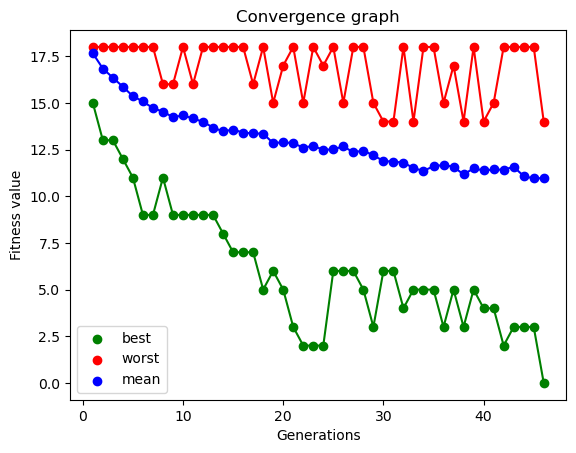

In [84]:
seed_value = 2

np.random.seed(seed_value)
random.seed(seed_value)

 # Define the parameters

mutation_rate_rows = 0.3
mutation_rate_init = 0.05
cross_rate = 0.2
cross_rate_rows = 0.1
function = total_error
tournament_size = 2
elite_size = 50

# Given matrix
given_matrix = np.array([
[0, 0, 9, 0, 0, 0, 1, 0, 0],
[2, 1, 7, 0, 0, 0, 3, 6, 8],
[0, 0, 0, 2, 0, 7, 0, 0, 0],
[0, 6, 4, 1, 0, 3, 5, 8, 0],
[0, 7, 0, 0, 0, 0, 0, 3, 0],
[1, 5, 0, 4, 2, 8, 0, 7, 9],
[0, 0, 0, 5, 8, 9, 0, 0, 0],
[4, 8, 5, 0, 0, 0, 2, 9, 3],
[0, 0, 6, 3, 0, 2, 8, 0, 0]
])

genetic_Algorithm(mutation_rate_rows, mutation_rate_init, cross_rate, cross_rate_rows, function, tournament_size, elite_size, given_matrix)